This notebook was written by Adam Smith to provide examples and experiments for the paper 
"Differential Privacy After the Fact: The Case of Congressional Reapportionment" by Zhun Deng, Cynthia Dwork, and Adam Smith. 

Requires Python 3.x.

Copyright Adam Smith, 2019.

In [1]:
import huntington_hill_DP as hh
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import math
import scipy.stats

%matplotlib inline

# Experiments with example data from Indian parliament

In [2]:
example_populations_table = pd.DataFrame(
    [["JAMMU & KASHMIR",10143700],["HIMACHAL PRADESH",6077900],["PUNJAB",24358999],
    ["CHANDIGARH",900635],["UTTARANCHAL",8489349],["HARYANA",21144564],["DELHI",13850507],
    ["RAJASTHAN",56507188],["UTTAR PRADESH",166197921],["BIHAR",82998509],
    ["SIKKIM",540851],["ARUNACHAL PRADESH",1097968],["NAGALAND",1990036],
    ["MANIPUR",2166788],["MIZORAM",888573],["TRIPURA",3199203],
    ["MEGHALAYA",2318822],["ASSAM",26655528],["WEST BENGAL",80176197],
    ["JHARKHAND",26945829],["ORISSA",36804660],["CHHATTISGARH",20833803],
    ["MADHYA PRADESH",60348023],["GUJARAT",50671017],["DAMAN & DIU",158204],
    ["DADRA & NAGAR HAVELI",220490],["MAHARASHTRA",96878627],["ANDHRA PRADESH",76210007],
    ["KARNATAKA",52850562],["GOA",1347668],["LAKSHADWEEP",60650],
    ["KERALA",31841374],["TAMIL NADU",62405679],["PONDICHERRY",974345],
    ["ANDAMAN & NICOBAR ISLANDS",356152]
    ] )

example_populations_array = example_populations_table[1].values

number_of_seats = 545

stats = hh.huntington_hill(example_populations_array, number_of_seats)

for x in ['representatives', 'distance to instability']:
    print("====")
    print(x, ":")
    print(stats[x])

====
representatives :
[ 5.  3. 13.  1.  4. 11.  7. 30. 87. 43.  1.  1.  1.  1.  1.  2.  1. 14.
 42. 14. 19. 11. 32. 26.  1.  1. 51. 40. 28.  1.  1. 17. 33.  1.  1.]
====
distance to instability :
60650.0


## How likely is noise addition to changed apportioned seats? 

Trying this with the Indian population data:

In [3]:
(n, e, d) = hh.hh_robustness_to_noise_of_instance(example_populations_array, 
                      number_of_seats,
                      epsilon = 0.00003, 
                      num_reps = 100)
print("Out of 100 trials, there were {} trials where the \
apportionment totals differed from the exact totals. \
Of those, the average number of seats that changed \
was {}. The distance to instability was {}.".format(n, e, d))

Out of 100 trials, there were 12 trials where the apportionment totals differed from the exact totals. Of those, the average number of seats that changed was 2.0. The distance to instability was 60650.0.


# Experiments with US Historical Data

First, we load the population data into memory. 

This data comes from two sources: 
* 1790 through 1990: https://www.census.gov/population/www/censusdata/pop1790-1990.html
* 2000, 2010, and 2017 (estimated): https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population 
* Note that the 2017 numbers don't actually come from a decennial census. They are just there for fun.

The data on the number of seats historically apportioned comes from 
https://en.wikipedia.org/wiki/United_States_congressional_apportionment

In [4]:
us_pops = pd.read_csv('historical_populations.csv', header = 0)

us_seats = pd.read_csv('historical_seats_apportioned.csv', header = 0)

Now let's delete the total US population as well as the District of Columbia


In [5]:
us_pops = us_pops.drop([0,9]) 

print(us_pops.columns)
us_pops.head()

Index(['Name', '2017', '2010', '2000', '1990', '1980', '1970', '1960', '1950',
       '1940', '1930', '1920', '1910', '1900', '1890', '1880', '1870', '1860',
       '1850', '1840', '1830', '1820', '1810', '1800', '1790',
       'Year of first census', 'No significant change since', 'FIPS Code'],
      dtype='object')


,Name,2017,2010,2000,1990,1980,1970,1960,1950,1940,...,1850,1840,1830,1820,1810,1800,1790,Year of first census,No significant change since,FIPS Code
1,Alabama,4833722,4779736,4447100,4040587,3893888,3444165,3266740,3061743,2832961,...,771623.0,590756.0,309527.0,127901.0,9046.0,1250.0,NaN,1800,1820,1.0
2,Alaska,739795,710231,626932,550043,401851,300382,226167,128643,72524,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1880,1880,2.0
3,Arizona,7016270,6392017,5130632,3665228,2718215,1770900,1302161,749587,499261,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1860,1870,4.0
4,Arkansas,2959373,2915918,2673400,2350725,2286435,1923295,1786272,1909511,1949387,...,209897.0,97574.0,30388.0,14273.0,1062.0,NaN,NaN,1810,1830,5.0
5,California,39536653,37253956,33871648,29760021,23667902,19953134,15717204,10586223,6907387,...,92597.0,NaN,NaN,NaN,NaN,NaN,NaN,1850,1860,6.0


We also need to process the number of seats apportioned in each Census year.

* According to Wikipeda, "Congress failed to pass any reapportionment to implement the 1920 United States Census so despite population shift, distribution of seats from 1913 remained in effect until 1933." For experiments, we will use the total from 1910. 

* For experiments with the 2017 estimates, we use the total from 2010.

Both of these fictitious numbers happen to be 435. 

In [6]:
us_seats.head()

,Year,1790,1800,1810,1820,1830,1840,1850,1860,1870,...,1910,1930,1940,1950,1960,1970,1980,1990,2000,2010
0,Number of seats apportioned,105,142,182,213,240,223,234,241,292,...,435,435,435,435,435,435,435,435,435,435


In [7]:
us_seats['1920'] = us_seats['1910']
us_seats['2017'] = us_seats['2010']

In [8]:
representatives2010 = hh.huntington_hill(us_pops['2010'].values, num_seats = 435)['representatives']
representatives1990 = hh.huntington_hill(us_pops['1990'].values, num_seats = 435)['representatives']

print(representatives2010)

[ 7.  1.  9.  4. 53.  7.  5.  1. 27. 14.  2.  2. 18.  9.  4.  4.  6.  6.
  2.  8.  9. 14.  8.  4.  8.  1.  3.  4.  2. 12.  3. 27. 13.  1. 16.  5.
  5. 18.  2.  7.  1.  9. 36.  4.  1. 11. 10.  3.  8.  1.]


In [9]:
list_of_years = us_pops.columns.drop(['Name', 'Year of first census',
       'No significant change since', 'FIPS Code'])

## How robust is the HH apportionment to noise? 

The following code repeatedly adds geometric noise to state populations and checks if the apportionment changes.  

In [10]:
for epsilon in [1.0, 0.1, 0.01, 0.001, 0.0001]:
    print("==============")
    print("Now trying epsilon = ", epsilon)
    print("Each row lists: year, number of seats, number of trials (out of 100) that yielded different apportionment, the average number of seats that changed, and the distance to instability for taht year's real numbers.")
    for year in list_of_years[0:13]: 
        (n,e, d) = hh.hh_robustness_to_noise_of_instance(us_pops[year].values, 
                          num_seats = us_seats[year][0],
                          epsilon = epsilon, 
                          num_reps = 100)
        print('{} {} {:3d}   {:.2f} {:.2f}'.format(year, us_seats[year][0], n, e, d))

Now trying epsilon =  1.0
Each row lists: year, number of seats, number of trials (out of 100) that yielded different apportionment, the average number of seats that changed, and the distance to instability for taht year's real numbers.
2017 435   0   0.00 7787.00
2010 435   0   0.00 12409.00
2000 435   0   0.00 692.00
1990 435   0   0.00 836.00
1980 435   0   0.00 7422.00
1970 435   0   0.00 693.00
1960 435   0   0.00 11436.00
1950 435   0   0.00 1876.00
1940 435   0   0.00 1180.00
1930 435   0   0.00 118.00
1920 435   0   0.00 3939.00
1910 435   0   0.00 5159.00
1900 386   0   0.00 4915.00
Now trying epsilon =  0.1
Each row lists: year, number of seats, number of trials (out of 100) that yielded different apportionment, the average number of seats that changed, and the distance to instability for taht year's real numbers.
2017 435   0   0.00 7787.00
2010 435   0   0.00 12409.00
2000 435   0   0.00 692.00
1990 435   0   0.00 836.00
1980 435   0   0.00 7422.00
1970 435   0   0.00 693.0

In [11]:
## Need to write code to handle years with missing populations. 

## Experiments with the projection to the nearest consistent set of populations

In [12]:
# Use the folowing code to force the notebook to reload the main package. 
#importlib.reload(hh)

As a test, we first ask how much the 2010 state populations would have to change in order to be consistent with the 2010 apportionment. As we might hope, the correct answer is __0__. 

In [13]:
output = hh.huntington_hill_projection(us_pops['2010'].values, representatives2010)
print( output['Distance'], np.average(output['Delta']))

0.0 0.0


To visualize how the algorithm works, we plot the magnitude of the changes we would get (y-axis) if we were to fix the threshold T to different values (x-axis). This curve is indeed convex, and its minimum (which is 0) occurs at the threshold actually used by the HH algorithm. 

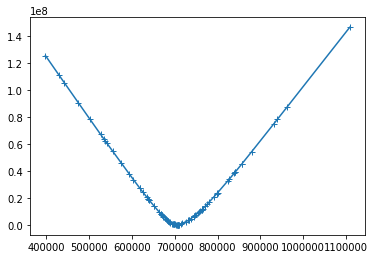

In [14]:
thresholds = output['All Thresholds']
distances = output['All Distances']
plt.plot(thresholds, distances, '+-')

Next, we ask how much the __2010__ state populations would have to change in order to be consistent with the __1990__ apportionment. The answer is pretty big: 22.2 M people (additons and deletions). 

In [15]:
output = hh.huntington_hill_projection(us_pops['2010'].values, representatives1990)
print( output['Distance'], np.average(output['Delta']))

22217657.0 75661.78


Again, we plot distances versus threhsolds. The curve is convex, with a minimum at 22.2 M.

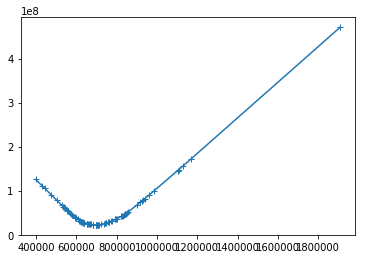

In [16]:
thresholds = output['All Thresholds']
distances = output['All Distances']
plt.plot(thresholds, distances, '+-')

Symmetrically, we ask how much the __1990__ state populations would have to change in order to be consistent with the __2010__ apportionment. The answer is again pretty big: 20.3M people (additions and deletions). 

20294642.0 3318.44


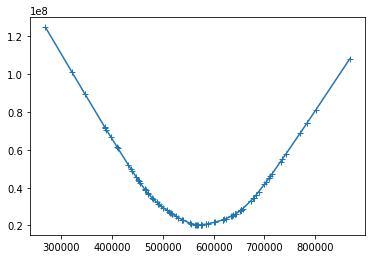

In [17]:
output = hh.huntington_hill_projection(us_pops['1990'].values, representatives2010)
print( output['Distance'], np.average(output['Delta']))
thresholds = output['All Thresholds']
distances = output['All Distances']
plt.plot(thresholds, distances, '+-')

The `huntington_hill_projection` function produces as output a Python dictionary with a load of relevant results. You can get the vector of projected populations, the vector of differences, the "threshold" (that is the last priority which the HH algorithm would have used when assigning a representative), the distance (the L1 norm of the vector of changes), and other intermediate values. 

In [18]:
output.keys()

dict_keys(['Projected populations', 'Delta', 'Threshold', 'Distance', 'All Thresholds', 'All Distances'])

## Main Experiment: How big are the changes needed for consistency?

This experiment looks at average L1 norm of the changes needed to transform noisy population statistics into stats that are consistent with the true apportionment for a particular year. We do this for several years, and several values of `epsilon`.

In [19]:
year_list = list_of_years[0:13]
distances_to_instab_list = []
num_seats_list = []
average_proj_distances = {} 
average_seats_changed = {}
frac_iterations_changed = {}

epsilon_list = [1.0, 0.1, 0.01, 0.001, 0.0001]
for epsilon in epsilon_list:
    print("==============")
    print("Now trying epsilon = ", epsilon)
    print('''Each row lists: year, number of seats, distance to instability of the true numbers, 
          number of trials (out of 100) that yielded different apportionment, the average number of 
          seats that changed, and the average l1 distance of the projection to the nearest set of 
          populations with the true apportionment.''')
    average_proj_distances_this_epsilon = []
    average_seats_changed_this_epsilon = [] 
    frac_iterations_changed_this_epsilon = []
    for year in year_list: 
        (n, e, avg_dist, d) = hh.hh_projection_after_noise_on_instance(us_pops[year].values, 
                          num_seats = us_seats[year][0],
                          epsilon = epsilon, 
                          num_reps = 100)
        if epsilon == epsilon_list[0]: # First time through, record distances. 
            distances_to_instab_list.append(d)
            num_seats_list.append(us_seats[year][0])
        average_proj_distances_this_epsilon.append(avg_dist)
        average_seats_changed_this_epsilon.append(e)
        frac_iterations_changed_this_epsilon.append(n / 100)
        print('{} {}  {:10.0f} {:3d}   {:3.2f} {:10.2f},'.format(year, us_seats[year][0], d, n, e, avg_dist))
    average_proj_distances[epsilon] = average_proj_distances_this_epsilon
    average_seats_changed[epsilon] = average_seats_changed_this_epsilon
    frac_iterations_changed[epsilon] = frac_iterations_changed_this_epsilon

Now trying epsilon =  1.0
Each row lists: year, number of seats, distance to instability of the true numbers, 
          number of trials (out of 100) that yielded different apportionment, the average number of 
          seats that changed, and the average l1 distance of the projection to the nearest set of 
          populations with the true apportionment.
2017 435        7787   0   0.00       0.00,
2010 435       12409   0   0.00       0.00,
2000 435         692   0   0.00       0.00,
1990 435         836   0   0.00       0.00,
1980 435        7422   0   0.00       0.00,
1970 435         693   0   0.00       0.00,
1960 435       11436   0   0.00       0.00,
1950 435        1876   0   0.00       0.00,
1940 435        1180   0   0.00       0.00,
1930 435         118   0   0.00       0.00,
1920 435        3939   0   0.00       0.00,
1910 435        5159   0   0.00       0.00,
1900 386        4915   0   0.00       0.00,
Now trying epsilon =  0.1
Each row lists: year, number of seats, d

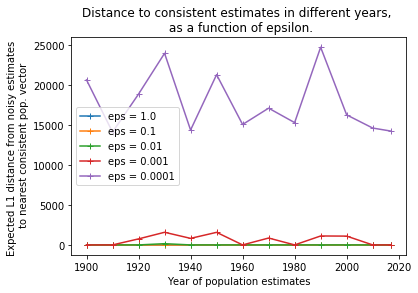

In [28]:
years_as_ints = [int(year) for year in year_list]

for epsilon in epsilon_list: 
    plt.plot(years_as_ints, average_proj_distances[epsilon], '+-', label = "eps = {}".format(epsilon))
    
plt.legend()
plt.xlabel("Year of population estimates")
plt.ylabel("Expected L1 distance from noisy estimates \n to nearest consistent pop. vector")
plt.title("Distance to consistent estimates in different years, \n as a function of epsilon.")
plt.savefig("proj-dist-v-year.pdf")

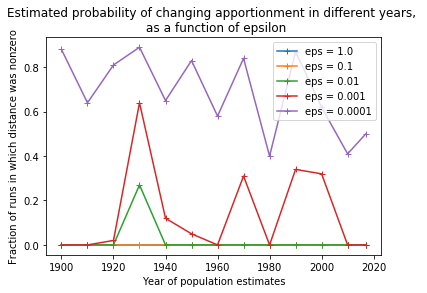

In [30]:
for epsilon in epsilon_list: 
    plt.plot(years_as_ints, frac_iterations_changed[epsilon], '+-', label = "eps = {}".format(epsilon))
    
plt.legend()
plt.xlabel("Year of population estimates")
plt.ylabel("Fraction of runs in which distance was nonzero")
plt.title("Estimated probability of changing apportionment in different years, \n as a function of epsilon")
plt.savefig("prob-change-v-year.pdf")

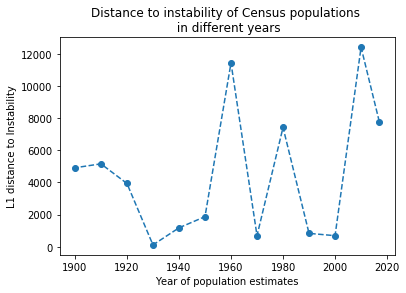

In [29]:
plt.plot(years_as_ints, distances_to_instab_list, 'o--')
plt.xlabel("Year of population estimates")
plt.ylabel("L1 distance to Instability")
plt.title("Distance to instability of Census populations \n in different years")
plt.savefig("instab-v-year.pdf")